In [1]:
import os
import random
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from ptflops import get_model_complexity_info
import optuna
from tqdm import tqdm
import timm

# Data paths based on the provided file structure
BASE_DIR = '/home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset'
TRAIN_SET_DIR = os.path.join(BASE_DIR, 'Train_set')
AUG_SET_DIR = os.path.join(BASE_DIR, 'Augmented_Set')
TEST_SET_DIR = os.path.join(BASE_DIR, 'Test_set')

# Model & Training Parameters
RANDOM_STATE = 42
IMG_SIZE = 256
CROP_SIZE = 224
BATCH_SIZE = 32
N_OPTUNA_TRIALS = 20  
OPTUNA_EPOCHS = 25     
FULL_TRAIN_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10 

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs('./efficientnet_lite_outputs', exist_ok=True)

# --- 2. Data Loading and Preparation ---
def load_image_paths(directories):
    """Loads image paths and labels from a list of directories."""
    all_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(directories[0]) if os.path.isdir(os.path.join(directories[0], d))])
    class_to_int = {name: i for i, name in enumerate(class_names)}
    int_to_class = {i: name for i, name in enumerate(class_names)}

    for directory in directories:
        for class_name in class_names:
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            image_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_paths.extend(image_files)
            all_labels.extend([class_to_int[class_name]] * len(image_files))
    return all_paths, all_labels, class_to_int, int_to_class

print("--- Loading Data ---")
# Combine original train and augmented sets for the training pool
train_val_paths, train_val_labels, class_to_int, int_to_class = load_image_paths([TRAIN_SET_DIR, AUG_SET_DIR])
test_paths, test_labels, _, _ = load_image_paths([TEST_SET_DIR])
num_classes = len(class_to_int)

print(f"Found {num_classes} classes: {list(class_to_int.keys())}")

# Stratified split for train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=RANDOM_STATE
)

print(f"Total training pool images: {len(train_val_paths)}")
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

class SugarcaneLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
        
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SugarcaneLeafDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SugarcaneLeafDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = SugarcaneLeafDataset(test_paths, test_labels, transform=val_test_transform)

# Handle class imbalance for training loader with WeightedRandomSampler
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- 3. Model Definition (EfficientNet-Lite with Timm) ---
class RegularizedEfficientNetLite(nn.Module):
    """
    A regularized EfficientNet-Lite model using the timm library.
    This class loads a pretrained EfficientNet-Lite, freezes a portion of its layers,
    and attaches a new custom classifier head.
    """
    def __init__(self, num_classes, dropout_rate1=0.5, dropout_rate2=0.5, freeze_ratio=0.5):
        super().__init__()
        self.timm_model_name = 'tf_efficientnet_lite0' # <-- Changed to EfficientNet-Lite
        
        # Load the base model from timm with pretrained weights.
        self.base_model = timm.create_model(self.timm_model_name, pretrained=True, num_classes=0)
        print(f"Loaded '{self.timm_model_name}' from timm with pretrained weights.")

        # Freeze layers based on the freeze_ratio
        all_params = list(self.base_model.parameters())
        num_to_freeze = int(len(all_params) * freeze_ratio)
        if num_to_freeze > 0:
            print(f"Freezing the first {num_to_freeze} of {len(all_params)} parameter groups.")
            for i, param in enumerate(all_params):
                if i < num_to_freeze:
                    param.requires_grad = False
        
        # Get the number of input features for the classifier
        in_features = self.base_model.num_features
        print(f"Base model feature dimension: {in_features}")
        
        # Replace the model's classifier with a new custom head
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate1),
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout_rate2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# --- 4. Training & Evaluation Functions ---
def train_epoch(model, loader, criterion, optimizer, device, grad_clip_norm=1.0):
    model.train()
    running_loss = 0.0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets, all_outputs = [], [], []
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    return loss, accuracy, all_preds, all_targets, np.array(all_outputs)
    
# --- 5. Hyperparameter Tuning with Optuna ---
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate1 = trial.suggest_float("dropout_rate1", 0.1, 0.6)
    dropout_rate2 = trial.suggest_float("dropout_rate2", 0.1, 0.6)
    freeze_ratio = trial.suggest_float("freeze_ratio", 0.0, 0.8)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    grad_clip = trial.suggest_float("grad_clip", 0.5, 2.0)

    # Model, Optimizer, Criterion
    model = RegularizedEfficientNetLite(num_classes, dropout_rate1, dropout_rate2, freeze_ratio).to(device) # <-- Use EfficientNet-Lite class
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Training loop for the trial
    for epoch in range(OPTUNA_EPOCHS):
        train_epoch(model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
        
        print(f"Trial {trial.number} | Epoch {epoch+1}/{OPTUNA_EPOCHS} | Val Acc: {val_acc:.2f}%")
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc
    
print("\n--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_OPTUNA_TRIALS) 

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value:.2f}%")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
best_hyperparams = best_trial.params

# --- 6. Final Model Training ---
print("\n--- Starting Final Training with Best Hyperparameters ---")
final_model = RegularizedEfficientNetLite( # <-- Use EfficientNet-Lite class
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)

final_optimizer = getattr(torch.optim, best_hyperparams["optimizer"])(
    final_model.parameters(), lr=best_hyperparams["lr"], weight_decay=best_hyperparams["weight_decay"]
)
final_criterion = nn.CrossEntropyLoss(label_smoothing=best_hyperparams["label_smoothing"])
final_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=FULL_TRAIN_EPOCHS)

# Calculate and print model complexity
try:
    macs, params = get_model_complexity_info(final_model, (3, CROP_SIZE, CROP_SIZE), as_strings=True, print_per_layer_stat=False, verbose=False)
    print(f"\nFinal Model Complexity: MACs: {macs}, Params: {params}")
except Exception as e:
    print(f"Could not calculate model complexity: {e}")
    
# Training loop with early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0
training_start_time = time.time()

for epoch in range(FULL_TRAIN_EPOCHS):
    train_loss = train_epoch(final_model, train_loader, final_criterion, final_optimizer, device, best_hyperparams["grad_clip"])
    _, train_acc, _, _, _ = evaluate(final_model, train_loader, final_criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(final_model, val_loader, final_criterion, device)
    
    final_scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{FULL_TRAIN_EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), './efficientnet_lite_outputs/best_model.pth') # <-- Save to correct directory
        print("  Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

total_training_duration = time.time() - training_start_time
print(f"Total final training time: {total_training_duration/60:.2f} minutes.")

# --- 7. Final Evaluation and Visualization ---
print("\n--- Final Evaluation on Test Set ---")
# Load the best model
best_model = RegularizedEfficientNetLite( # <-- Use EfficientNet-Lite class
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)
best_model.load_state_dict(torch.load('./efficientnet_lite_outputs/best_model.pth', map_location=device)) # <-- Load from correct directory

# Evaluate on test set
inference_start_time = time.time()
test_loss, test_acc, test_preds, test_targets, test_outputs = evaluate(best_model, test_loader, final_criterion, device)
inference_duration = time.time() - inference_start_time
avg_inference_time = (inference_duration / len(test_dataset)) * 1000

print(f"Test Set Performance: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
print(f"Average inference time per image: {avg_inference_time:.2f} ms")

[I 2025-07-18 12:54:43,101] A new study created in memory with name: no-name-a27b7f93-f972-4956-9f2d-75bdadd992ef


Using device: cuda
--- Loading Data ---
Found 17 classes: ['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Eye_Spot', 'Grassy_Shoot', 'Healthy', 'Mosaic', 'Pokkah_Boeng', 'RedRot', 'Red_Leaf_Spot', 'Ring_Spot', 'Rust', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']
Total training pool images: 11314
Training samples: 9051
Validation samples: 2263
Test samples: 1414

--- Starting Hyperparameter Optimization with Optuna ---
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 102 of 147 parameter groups.
Base model feature dimension: 1280
Trial 0 | Epoch 1/25 | Val Acc: 77.11%
Trial 0 | Epoch 2/25 | Val Acc: 88.11%
Trial 0 | Epoch 3/25 | Val Acc: 89.92%
Trial 0 | Epoch 4/25 | Val Acc: 90.23%
Trial 0 | Epoch 5/25 | Val Acc: 90.90%
Trial 0 | Epoch 6/25 | Val Acc: 92.49%
Trial 0 | Epoch 7/25 | Val Acc: 91.74%
Trial 0 | Epoch 8/25 | Val Acc: 92.40%
Trial 0 | Epoch 9/25 | Val Acc: 92.71%
Trial 0 | Epoch 10/25 | Val Acc: 94.79%
Trial 0 | Epo

[I 2025-07-18 13:08:07,519] Trial 0 finished with value: 93.06230667255855 and parameters: {'lr': 0.0034504571310988016, 'optimizer': 'Adam', 'weight_decay': 1.5758912442056647e-06, 'dropout_rate1': 0.4131578937005508, 'dropout_rate2': 0.3218683833589223, 'freeze_ratio': 0.6945811036371055, 'label_smoothing': 0.0584021312131263, 'grad_clip': 0.6478563149784866}. Best is trial 0 with value: 93.06230667255855.


Trial 0 | Epoch 25/25 | Val Acc: 93.06%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 105 of 147 parameter groups.
Base model feature dimension: 1280
Trial 1 | Epoch 1/25 | Val Acc: 90.10%
Trial 1 | Epoch 2/25 | Val Acc: 93.33%
Trial 1 | Epoch 3/25 | Val Acc: 92.84%
Trial 1 | Epoch 4/25 | Val Acc: 95.93%
Trial 1 | Epoch 5/25 | Val Acc: 96.82%
Trial 1 | Epoch 6/25 | Val Acc: 95.89%
Trial 1 | Epoch 7/25 | Val Acc: 96.77%
Trial 1 | Epoch 8/25 | Val Acc: 96.86%
Trial 1 | Epoch 9/25 | Val Acc: 96.33%
Trial 1 | Epoch 10/25 | Val Acc: 96.73%
Trial 1 | Epoch 11/25 | Val Acc: 97.22%
Trial 1 | Epoch 12/25 | Val Acc: 96.24%
Trial 1 | Epoch 13/25 | Val Acc: 97.39%
Trial 1 | Epoch 14/25 | Val Acc: 96.16%
Trial 1 | Epoch 15/25 | Val Acc: 97.17%
Trial 1 | Epoch 16/25 | Val Acc: 97.13%
Trial 1 | Epoch 17/25 | Val Acc: 97.48%
Trial 1 | Epoch 18/25 | Val Acc: 97.04%
Trial 1 | Epoch 19/25 | Val Acc: 97.17%
Trial 1 | Epoch 20/25 | Val Acc: 96.29%
Trial 1 | Epoch 21/2

[I 2025-07-18 13:21:47,236] Trial 1 finished with value: 94.74149359257622 and parameters: {'lr': 0.0006024622570606195, 'optimizer': 'AdamW', 'weight_decay': 0.0005971221951138545, 'dropout_rate1': 0.47614689450070236, 'dropout_rate2': 0.35668791307553827, 'freeze_ratio': 0.7178464350016319, 'label_smoothing': 0.1773048103531153, 'grad_clip': 1.1992427862002282}. Best is trial 1 with value: 94.74149359257622.


Trial 1 | Epoch 25/25 | Val Acc: 94.74%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 42 of 147 parameter groups.
Base model feature dimension: 1280
Trial 2 | Epoch 1/25 | Val Acc: 71.98%
Trial 2 | Epoch 2/25 | Val Acc: 86.48%
Trial 2 | Epoch 3/25 | Val Acc: 91.74%
Trial 2 | Epoch 4/25 | Val Acc: 93.59%
Trial 2 | Epoch 5/25 | Val Acc: 94.70%
Trial 2 | Epoch 6/25 | Val Acc: 96.07%
Trial 2 | Epoch 7/25 | Val Acc: 96.51%
Trial 2 | Epoch 8/25 | Val Acc: 97.22%
Trial 2 | Epoch 9/25 | Val Acc: 97.44%
Trial 2 | Epoch 10/25 | Val Acc: 97.13%
Trial 2 | Epoch 11/25 | Val Acc: 97.30%
Trial 2 | Epoch 12/25 | Val Acc: 97.44%
Trial 2 | Epoch 13/25 | Val Acc: 97.53%
Trial 2 | Epoch 14/25 | Val Acc: 97.30%
Trial 2 | Epoch 15/25 | Val Acc: 97.57%
Trial 2 | Epoch 16/25 | Val Acc: 97.88%
Trial 2 | Epoch 17/25 | Val Acc: 97.70%
Trial 2 | Epoch 18/25 | Val Acc: 97.39%
Trial 2 | Epoch 19/25 | Val Acc: 97.66%
Trial 2 | Epoch 20/25 | Val Acc: 97.97%
Trial 2 | Epoch 21/25

[I 2025-07-18 13:35:31,054] Trial 2 finished with value: 98.18824569155987 and parameters: {'lr': 4.056044535432783e-05, 'optimizer': 'Adam', 'weight_decay': 0.0003699521137551432, 'dropout_rate1': 0.5758165308101277, 'dropout_rate2': 0.2760135620156835, 'freeze_ratio': 0.28976175273593857, 'label_smoothing': 0.01940457011293202, 'grad_clip': 1.7870418141019226}. Best is trial 2 with value: 98.18824569155987.


Trial 2 | Epoch 25/25 | Val Acc: 98.19%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 22 of 147 parameter groups.
Base model feature dimension: 1280
Trial 3 | Epoch 1/25 | Val Acc: 92.09%
Trial 3 | Epoch 2/25 | Val Acc: 95.23%
Trial 3 | Epoch 3/25 | Val Acc: 95.14%
Trial 3 | Epoch 4/25 | Val Acc: 94.70%
Trial 3 | Epoch 5/25 | Val Acc: 94.83%
Trial 3 | Epoch 6/25 | Val Acc: 96.24%
Trial 3 | Epoch 7/25 | Val Acc: 96.51%
Trial 3 | Epoch 8/25 | Val Acc: 95.71%
Trial 3 | Epoch 9/25 | Val Acc: 96.95%
Trial 3 | Epoch 10/25 | Val Acc: 96.11%
Trial 3 | Epoch 11/25 | Val Acc: 96.82%
Trial 3 | Epoch 12/25 | Val Acc: 96.29%
Trial 3 | Epoch 13/25 | Val Acc: 94.21%
Trial 3 | Epoch 14/25 | Val Acc: 96.60%
Trial 3 | Epoch 15/25 | Val Acc: 96.55%
Trial 3 | Epoch 16/25 | Val Acc: 95.89%
Trial 3 | Epoch 17/25 | Val Acc: 96.73%
Trial 3 | Epoch 18/25 | Val Acc: 96.07%
Trial 3 | Epoch 19/25 | Val Acc: 96.16%
Trial 3 | Epoch 20/25 | Val Acc: 96.20%
Trial 3 | Epoch 21/25

[I 2025-07-18 13:49:13,138] Trial 3 finished with value: 96.5974370304905 and parameters: {'lr': 0.0003615519809245347, 'optimizer': 'Adam', 'weight_decay': 0.00045490949350905104, 'dropout_rate1': 0.34549853588535695, 'dropout_rate2': 0.20473706570768682, 'freeze_ratio': 0.15040931008449665, 'label_smoothing': 0.1780589324223133, 'grad_clip': 0.9300722354204733}. Best is trial 2 with value: 98.18824569155987.


Trial 3 | Epoch 25/25 | Val Acc: 96.60%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 39 of 147 parameter groups.
Base model feature dimension: 1280
Trial 4 | Epoch 1/25 | Val Acc: 50.20%
Trial 4 | Epoch 2/25 | Val Acc: 68.63%
Trial 4 | Epoch 3/25 | Val Acc: 76.84%
Trial 4 | Epoch 4/25 | Val Acc: 82.19%
Trial 4 | Epoch 5/25 | Val Acc: 84.18%
Trial 4 | Epoch 6/25 | Val Acc: 89.17%
Trial 4 | Epoch 7/25 | Val Acc: 90.06%
Trial 4 | Epoch 8/25 | Val Acc: 91.74%
Trial 4 | Epoch 9/25 | Val Acc: 92.40%
Trial 4 | Epoch 10/25 | Val Acc: 93.42%
Trial 4 | Epoch 11/25 | Val Acc: 93.81%
Trial 4 | Epoch 12/25 | Val Acc: 94.65%
Trial 4 | Epoch 13/25 | Val Acc: 94.92%
Trial 4 | Epoch 14/25 | Val Acc: 94.92%
Trial 4 | Epoch 15/25 | Val Acc: 95.63%
Trial 4 | Epoch 16/25 | Val Acc: 95.58%
Trial 4 | Epoch 17/25 | Val Acc: 96.02%
Trial 4 | Epoch 18/25 | Val Acc: 95.80%
Trial 4 | Epoch 19/25 | Val Acc: 96.42%
Trial 4 | Epoch 20/25 | Val Acc: 96.55%
Trial 4 | Epoch 21/25

[I 2025-07-18 14:03:00,140] Trial 4 finished with value: 97.17189571365444 and parameters: {'lr': 1.4407504117242153e-05, 'optimizer': 'AdamW', 'weight_decay': 0.00288872959502942, 'dropout_rate1': 0.38027936272756835, 'dropout_rate2': 0.5485855179412935, 'freeze_ratio': 0.26890707940050146, 'label_smoothing': 0.1533539829674644, 'grad_clip': 1.8521026714149376}. Best is trial 2 with value: 98.18824569155987.


Trial 4 | Epoch 25/25 | Val Acc: 97.17%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 53 of 147 parameter groups.
Base model feature dimension: 1280
Trial 5 | Epoch 1/25 | Val Acc: 90.28%
Trial 5 | Epoch 2/25 | Val Acc: 95.67%
Trial 5 | Epoch 3/25 | Val Acc: 96.95%
Trial 5 | Epoch 4/25 | Val Acc: 97.00%
Trial 5 | Epoch 5/25 | Val Acc: 97.35%
Trial 5 | Epoch 6/25 | Val Acc: 97.48%
Trial 5 | Epoch 7/25 | Val Acc: 97.22%
Trial 5 | Epoch 8/25 | Val Acc: 97.17%
Trial 5 | Epoch 9/25 | Val Acc: 96.86%
Trial 5 | Epoch 10/25 | Val Acc: 98.01%
Trial 5 | Epoch 11/25 | Val Acc: 97.66%
Trial 5 | Epoch 12/25 | Val Acc: 97.83%
Trial 5 | Epoch 13/25 | Val Acc: 97.66%
Trial 5 | Epoch 14/25 | Val Acc: 98.19%
Trial 5 | Epoch 15/25 | Val Acc: 98.28%
Trial 5 | Epoch 16/25 | Val Acc: 97.75%
Trial 5 | Epoch 17/25 | Val Acc: 97.88%
Trial 5 | Epoch 18/25 | Val Acc: 97.97%
Trial 5 | Epoch 19/25 | Val Acc: 97.75%
Trial 5 | Epoch 20/25 | Val Acc: 96.64%
Trial 5 | Epoch 21/25

[I 2025-07-18 14:16:57,785] Trial 5 finished with value: 97.87892178524083 and parameters: {'lr': 0.00045335427907016134, 'optimizer': 'Adam', 'weight_decay': 1.26812593321534e-06, 'dropout_rate1': 0.1373559908008953, 'dropout_rate2': 0.5418861998902103, 'freeze_ratio': 0.36056400017560186, 'label_smoothing': 0.12138110306807753, 'grad_clip': 0.5441353179371538}. Best is trial 2 with value: 98.18824569155987.


Trial 5 | Epoch 25/25 | Val Acc: 97.88%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 44 of 147 parameter groups.
Base model feature dimension: 1280
Trial 6 | Epoch 1/25 | Val Acc: 85.55%


[I 2025-07-18 14:18:06,534] Trial 6 pruned. 


Trial 6 | Epoch 2/25 | Val Acc: 86.30%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 2 of 147 parameter groups.
Base model feature dimension: 1280
Trial 7 | Epoch 1/25 | Val Acc: 87.63%
Trial 7 | Epoch 2/25 | Val Acc: 94.08%
Trial 7 | Epoch 3/25 | Val Acc: 95.98%
Trial 7 | Epoch 4/25 | Val Acc: 95.89%
Trial 7 | Epoch 5/25 | Val Acc: 97.35%
Trial 7 | Epoch 6/25 | Val Acc: 97.83%
Trial 7 | Epoch 7/25 | Val Acc: 97.70%
Trial 7 | Epoch 8/25 | Val Acc: 98.10%
Trial 7 | Epoch 9/25 | Val Acc: 98.06%
Trial 7 | Epoch 10/25 | Val Acc: 97.57%
Trial 7 | Epoch 11/25 | Val Acc: 98.01%
Trial 7 | Epoch 12/25 | Val Acc: 98.28%
Trial 7 | Epoch 13/25 | Val Acc: 98.14%
Trial 7 | Epoch 14/25 | Val Acc: 98.06%
Trial 7 | Epoch 15/25 | Val Acc: 98.19%
Trial 7 | Epoch 16/25 | Val Acc: 98.41%
Trial 7 | Epoch 17/25 | Val Acc: 98.63%
Trial 7 | Epoch 18/25 | Val Acc: 98.32%
Trial 7 | Epoch 19/25 | Val Acc: 98.50%
Trial 7 | Epoch 20/25 | Val Acc: 98.54%
Trial 7 | Epoch 21/25 |

[I 2025-07-18 14:33:54,619] Trial 7 finished with value: 98.36500220945648 and parameters: {'lr': 8.374085953811647e-05, 'optimizer': 'AdamW', 'weight_decay': 4.8012242190522075e-06, 'dropout_rate1': 0.15824169192146162, 'dropout_rate2': 0.5326046467688539, 'freeze_ratio': 0.015556085838055367, 'label_smoothing': 0.10727716615022101, 'grad_clip': 0.8299405988341435}. Best is trial 7 with value: 98.36500220945648.


Trial 7 | Epoch 25/25 | Val Acc: 98.37%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 77 of 147 parameter groups.
Base model feature dimension: 1280
Trial 8 | Epoch 1/25 | Val Acc: 90.01%
Trial 8 | Epoch 2/25 | Val Acc: 93.90%
Trial 8 | Epoch 3/25 | Val Acc: 95.76%
Trial 8 | Epoch 4/25 | Val Acc: 96.07%
Trial 8 | Epoch 5/25 | Val Acc: 96.73%
Trial 8 | Epoch 6/25 | Val Acc: 97.17%
Trial 8 | Epoch 7/25 | Val Acc: 97.44%
Trial 8 | Epoch 8/25 | Val Acc: 97.48%
Trial 8 | Epoch 9/25 | Val Acc: 97.57%
Trial 8 | Epoch 10/25 | Val Acc: 97.13%
Trial 8 | Epoch 11/25 | Val Acc: 97.83%
Trial 8 | Epoch 12/25 | Val Acc: 97.44%
Trial 8 | Epoch 13/25 | Val Acc: 97.75%
Trial 8 | Epoch 14/25 | Val Acc: 97.70%
Trial 8 | Epoch 15/25 | Val Acc: 98.06%
Trial 8 | Epoch 16/25 | Val Acc: 97.57%
Trial 8 | Epoch 17/25 | Val Acc: 96.91%
Trial 8 | Epoch 18/25 | Val Acc: 97.83%
Trial 8 | Epoch 19/25 | Val Acc: 97.53%
Trial 8 | Epoch 20/25 | Val Acc: 97.79%
Trial 8 | Epoch 21/25

[I 2025-07-18 14:47:57,978] Trial 8 finished with value: 97.43703049049934 and parameters: {'lr': 0.00025751750571882974, 'optimizer': 'AdamW', 'weight_decay': 0.0002029991933488443, 'dropout_rate1': 0.5773798946914487, 'dropout_rate2': 0.46882830922548346, 'freeze_ratio': 0.5293874996810942, 'label_smoothing': 0.17446487687871376, 'grad_clip': 1.0442952355302493}. Best is trial 7 with value: 98.36500220945648.


Trial 8 | Epoch 25/25 | Val Acc: 97.44%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 39 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:48:34,128] Trial 9 pruned. 


Trial 9 | Epoch 1/25 | Val Acc: 81.35%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 2 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:49:08,717] Trial 10 pruned. 


Trial 10 | Epoch 1/25 | Val Acc: 88.73%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 8 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:49:43,528] Trial 11 pruned. 


Trial 11 | Epoch 1/25 | Val Acc: 81.48%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 76 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:50:15,836] Trial 12 pruned. 


Trial 12 | Epoch 1/25 | Val Acc: 84.31%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 22 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:50:48,868] Trial 13 pruned. 


Trial 13 | Epoch 1/25 | Val Acc: 52.32%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 70 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:51:23,608] Trial 14 pruned. 


Trial 14 | Epoch 1/25 | Val Acc: 87.23%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 21 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:51:58,836] Trial 15 pruned. 


Trial 15 | Epoch 1/25 | Val Acc: 79.94%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 91 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 14:52:34,125] Trial 16 pruned. 


Trial 16 | Epoch 1/25 | Val Acc: 73.44%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 57 of 147 parameter groups.
Base model feature dimension: 1280
Trial 17 | Epoch 1/25 | Val Acc: 89.79%
Trial 17 | Epoch 2/25 | Val Acc: 94.12%
Trial 17 | Epoch 3/25 | Val Acc: 95.18%
Trial 17 | Epoch 4/25 | Val Acc: 96.95%
Trial 17 | Epoch 5/25 | Val Acc: 96.55%
Trial 17 | Epoch 6/25 | Val Acc: 97.44%
Trial 17 | Epoch 7/25 | Val Acc: 97.48%
Trial 17 | Epoch 8/25 | Val Acc: 97.92%
Trial 17 | Epoch 9/25 | Val Acc: 97.70%
Trial 17 | Epoch 10/25 | Val Acc: 98.01%
Trial 17 | Epoch 11/25 | Val Acc: 97.83%
Trial 17 | Epoch 12/25 | Val Acc: 97.70%
Trial 17 | Epoch 13/25 | Val Acc: 98.01%
Trial 17 | Epoch 14/25 | Val Acc: 97.83%
Trial 17 | Epoch 15/25 | Val Acc: 98.06%
Trial 17 | Epoch 16/25 | Val Acc: 97.92%
Trial 17 | Epoch 17/25 | Val Acc: 97.83%
Trial 17 | Epoch 18/25 | Val Acc: 98.23%
Trial 17 | Epoch 19/25 | Val Acc: 97.79%
Trial 17 | Epoch 20/25 | Val Acc: 98.41%
T

[I 2025-07-18 15:06:45,927] Trial 17 finished with value: 98.27662395050818 and parameters: {'lr': 0.00017383757610329095, 'optimizer': 'Adam', 'weight_decay': 5.9467302864916894e-05, 'dropout_rate1': 0.4794924893205731, 'dropout_rate2': 0.4355319299134208, 'freeze_ratio': 0.39353023425468525, 'label_smoothing': 0.09714834047237918, 'grad_clip': 0.774232156150756}. Best is trial 7 with value: 98.36500220945648.


Trial 17 | Epoch 25/25 | Val Acc: 98.28%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 60 of 147 parameter groups.
Base model feature dimension: 1280
Trial 18 | Epoch 1/25 | Val Acc: 91.74%
Trial 18 | Epoch 2/25 | Val Acc: 94.61%
Trial 18 | Epoch 3/25 | Val Acc: 95.76%
Trial 18 | Epoch 4/25 | Val Acc: 96.86%
Trial 18 | Epoch 5/25 | Val Acc: 97.75%
Trial 18 | Epoch 6/25 | Val Acc: 97.39%
Trial 18 | Epoch 7/25 | Val Acc: 97.57%
Trial 18 | Epoch 8/25 | Val Acc: 97.26%
Trial 18 | Epoch 9/25 | Val Acc: 97.88%
Trial 18 | Epoch 10/25 | Val Acc: 97.92%
Trial 18 | Epoch 11/25 | Val Acc: 98.19%
Trial 18 | Epoch 12/25 | Val Acc: 98.10%
Trial 18 | Epoch 13/25 | Val Acc: 97.66%
Trial 18 | Epoch 14/25 | Val Acc: 97.97%
Trial 18 | Epoch 15/25 | Val Acc: 98.01%
Trial 18 | Epoch 16/25 | Val Acc: 98.50%
Trial 18 | Epoch 17/25 | Val Acc: 98.10%
Trial 18 | Epoch 18/25 | Val Acc: 97.97%
Trial 18 | Epoch 19/25 | Val Acc: 97.88%
Trial 18 | Epoch 20/25 | Val Acc: 97.48%


[I 2025-07-18 15:22:11,317] Trial 18 finished with value: 98.05567830313743 and parameters: {'lr': 0.00017798356713000034, 'optimizer': 'Adam', 'weight_decay': 5.70639448425374e-05, 'dropout_rate1': 0.4813016724355962, 'dropout_rate2': 0.4557522035269792, 'freeze_ratio': 0.4127198007757586, 'label_smoothing': 0.09861574478132594, 'grad_clip': 0.7719491998273598}. Best is trial 7 with value: 98.36500220945648.


Trial 18 | Epoch 25/25 | Val Acc: 98.06%
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 114 of 147 parameter groups.
Base model feature dimension: 1280


[I 2025-07-18 15:22:52,581] Trial 19 pruned. 


Trial 19 | Epoch 1/25 | Val Acc: 66.81%
Number of finished trials:  20
Best trial:
  Value: 98.37%
  Params: 
    lr: 8.374085953811647e-05
    optimizer: AdamW
    weight_decay: 4.8012242190522075e-06
    dropout_rate1: 0.15824169192146162
    dropout_rate2: 0.5326046467688539
    freeze_ratio: 0.015556085838055367
    label_smoothing: 0.10727716615022101
    grad_clip: 0.8299405988341435

--- Starting Final Training with Best Hyperparameters ---
Loaded 'tf_efficientnet_lite0' from timm with pretrained weights.
Freezing the first 2 of 147 parameter groups.
Base model feature dimension: 1280

Final Model Complexity: MACs: 373.91 MMac, Params: 4.7 M
Epoch 1/100 | Train Loss: 1.5310, Acc: 92.00% | Val Loss: 1.0377, Acc: 86.92%
  Validation loss decreased. Model saved.
Epoch 2/100 | Train Loss: 0.9313, Acc: 97.87% | Val Loss: 0.8848, Acc: 93.77%
  Validation loss decreased. Model saved.
Epoch 3/100 | Train Loss: 0.8192, Acc: 99.02% | Val Loss: 0.8546, Acc: 95.10%
  Validation loss decreas

Saved convergence plots to ./efficientnet_lite_outputs/convergence_plots.png

Classification Report (Test Set):
                   precision    recall  f1-score   support

Banded_Chlorosis       0.97      0.98      0.97        59
      Brown_Rust       0.94      1.00      0.97        33
      Brown_Spot       0.97      0.99      0.98       204
    Dried_Leaves       0.97      1.00      0.99        37
        Eye_Spot       1.00      0.93      0.97        15
    Grassy_Shoot       1.00      1.00      1.00        58
         Healthy       0.98      0.99      0.99       186
          Mosaic       0.94      0.97      0.95        76
    Pokkah_Boeng       1.00      1.00      1.00        46
          RedRot       0.99      0.99      0.99       147
   Red_Leaf_Spot       0.89      0.89      0.89         9
       Ring_Spot       1.00      1.00      1.00        17
            Rust       1.00      0.98      0.99        89
        Sett_Rot       1.00      1.00      1.00        96
            Smut

Extracting features for t-SNE: 100%|██████████| 45/45 [00:04<00:00,  9.40it/s]
/home/du/anaconda3/envs/sakib_rme/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved t-SNE plot by class to ./efficientnet_lite_outputs/tsne_by_class.png
Saved t-SNE plot by confidence to ./efficientnet_lite_outputs/tsne_by_confidence.png

Found 28 misclassified images. Plotting confidence for a few examples.
Saved confidence plots for misclassified samples to ./efficientnet_lite_outputs/misclassified_confidence.png

Script finished successfully. All artifacts are in the './efficientnet_lite_outputs' directory.


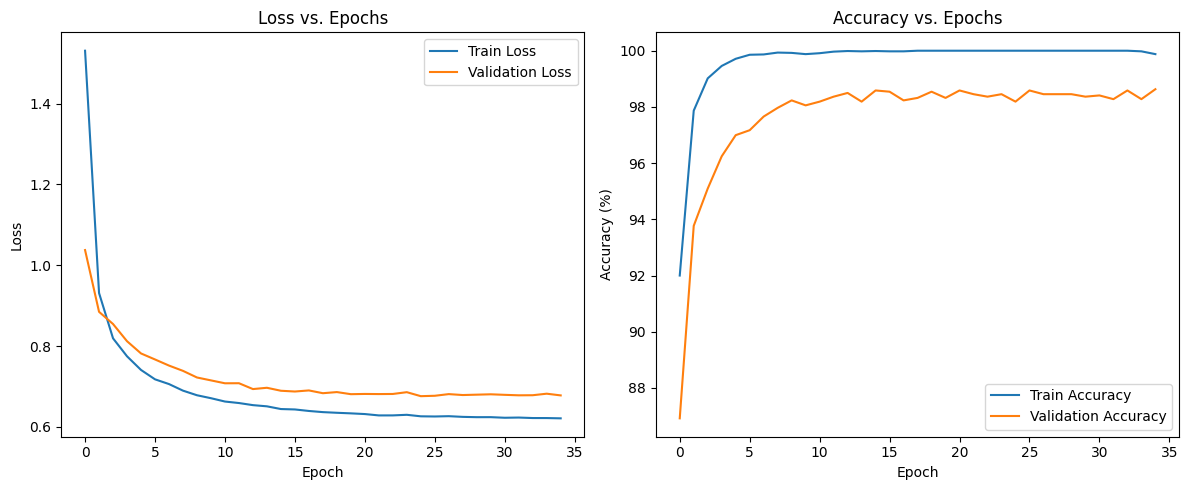

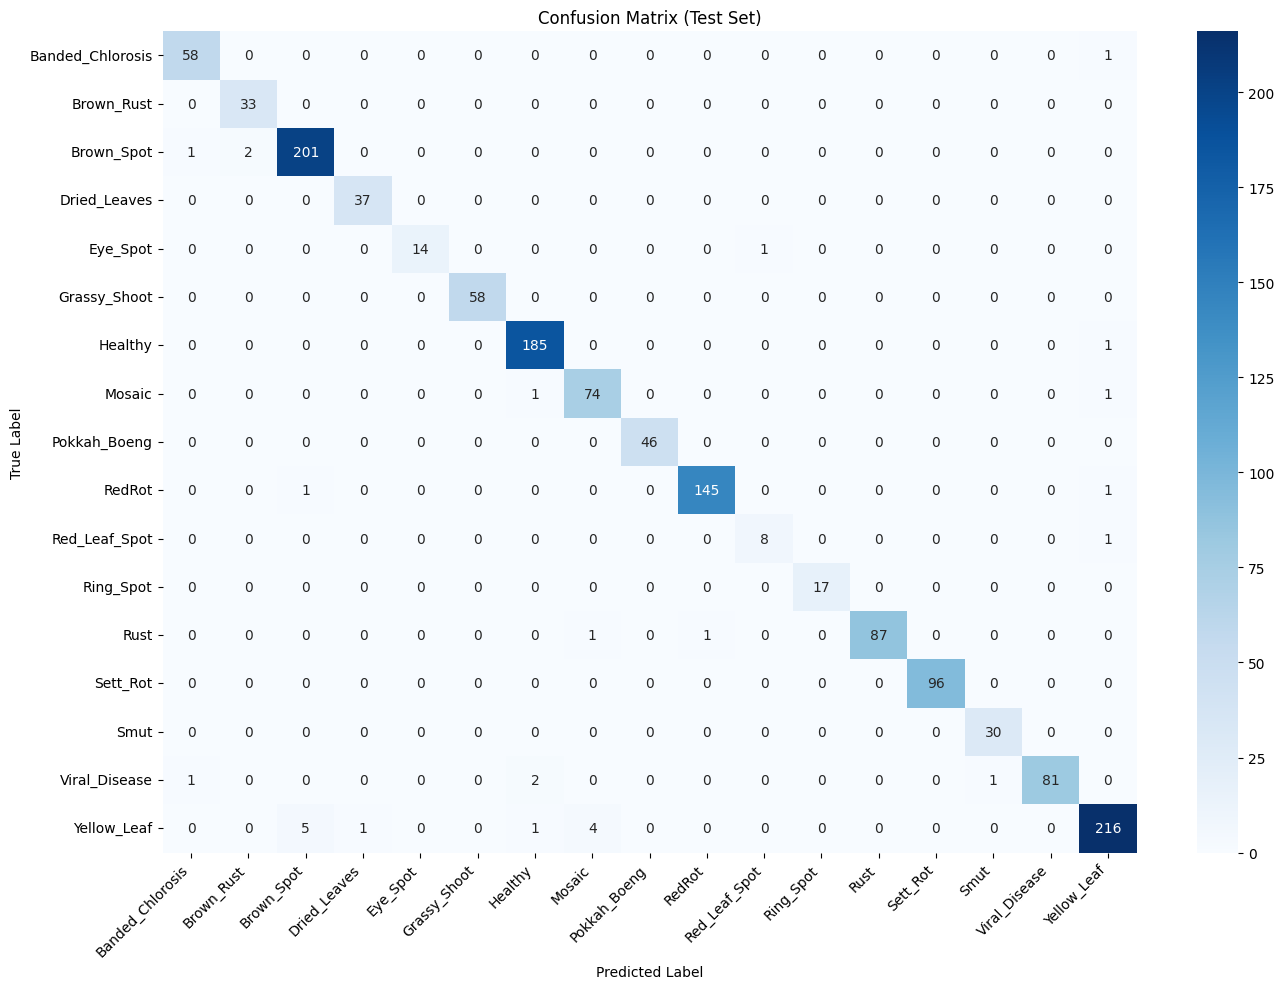

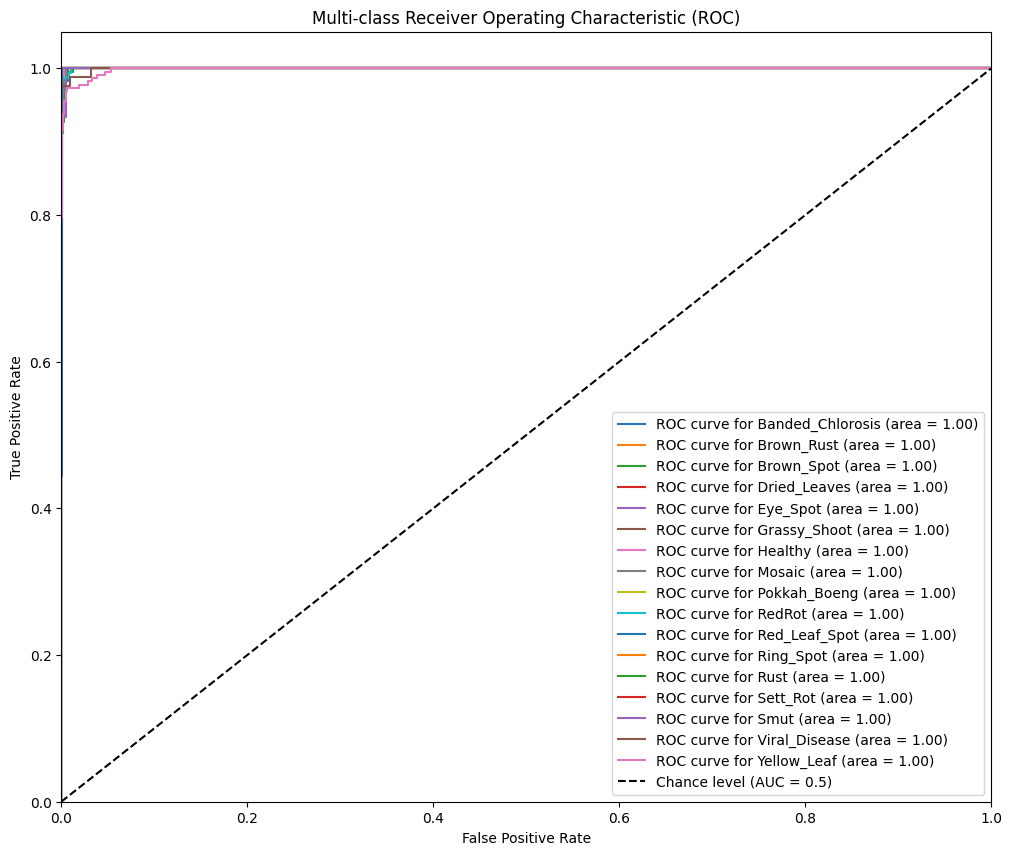

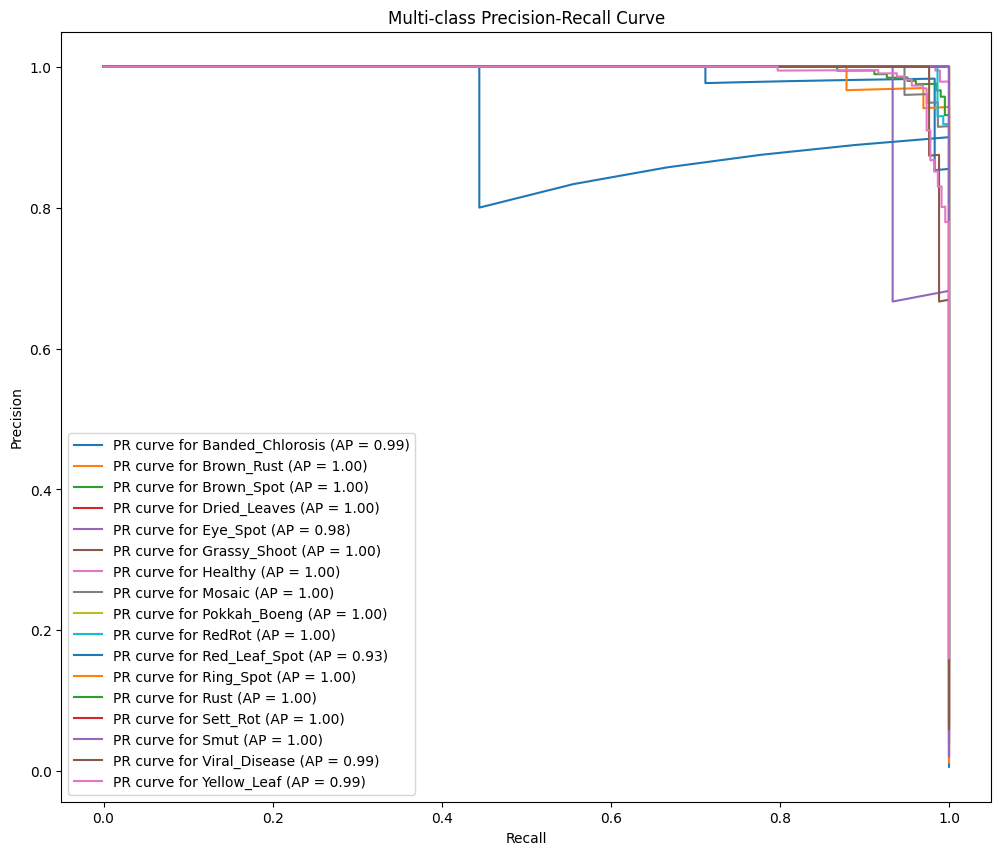

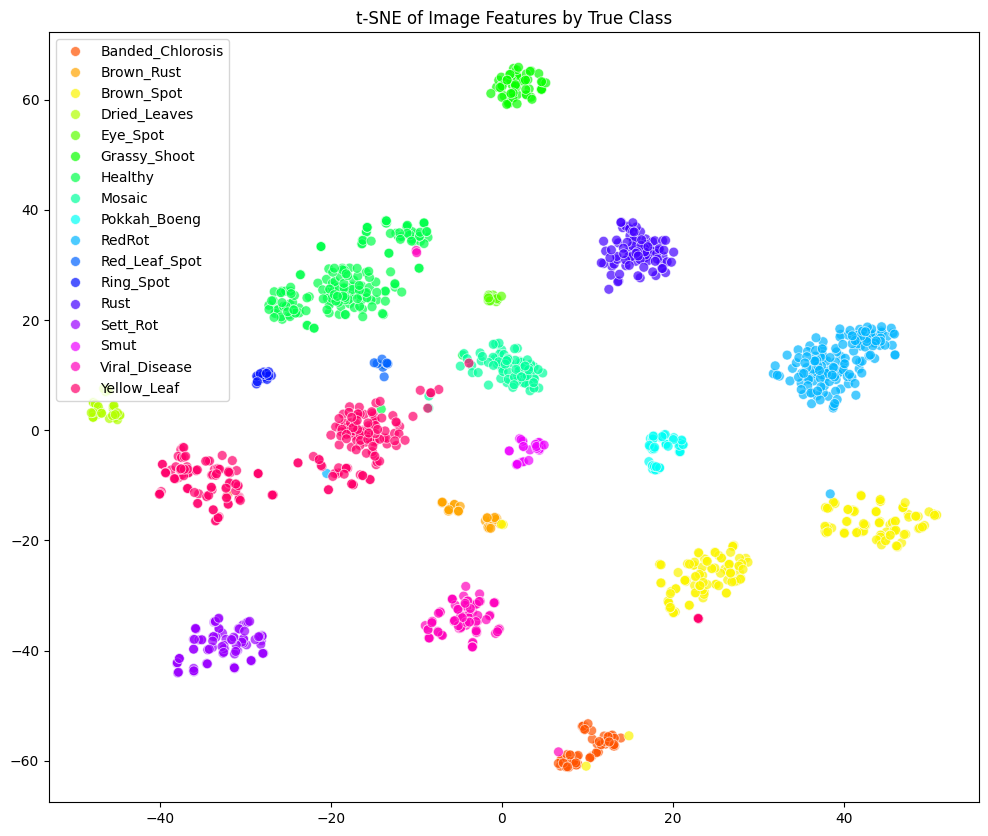

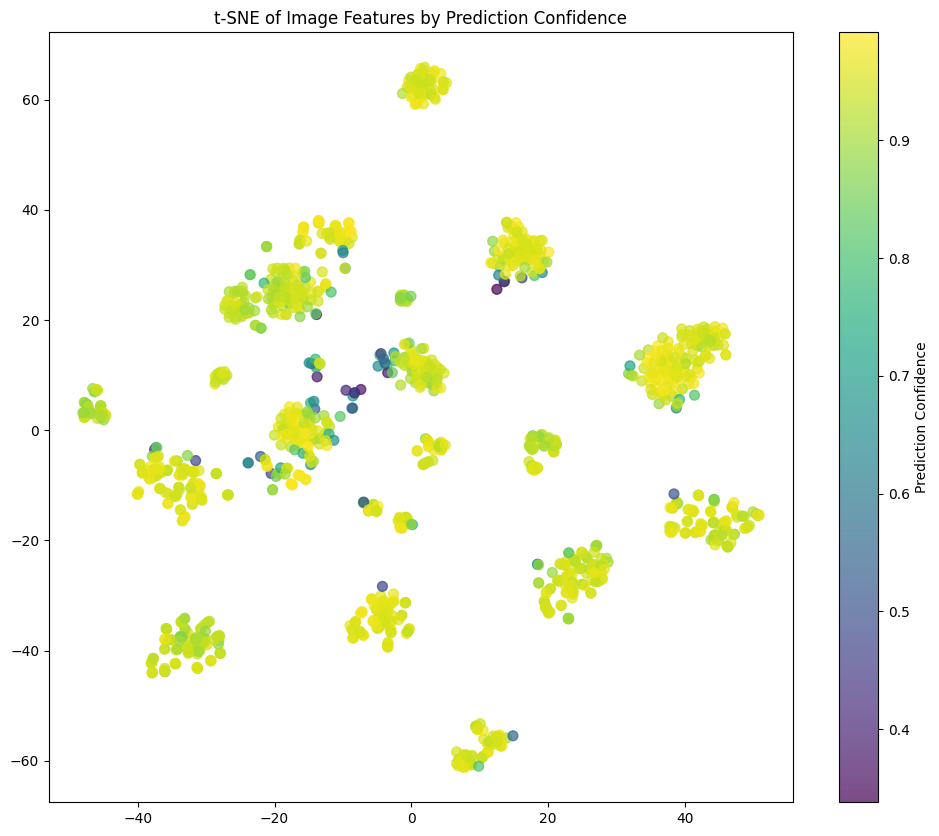

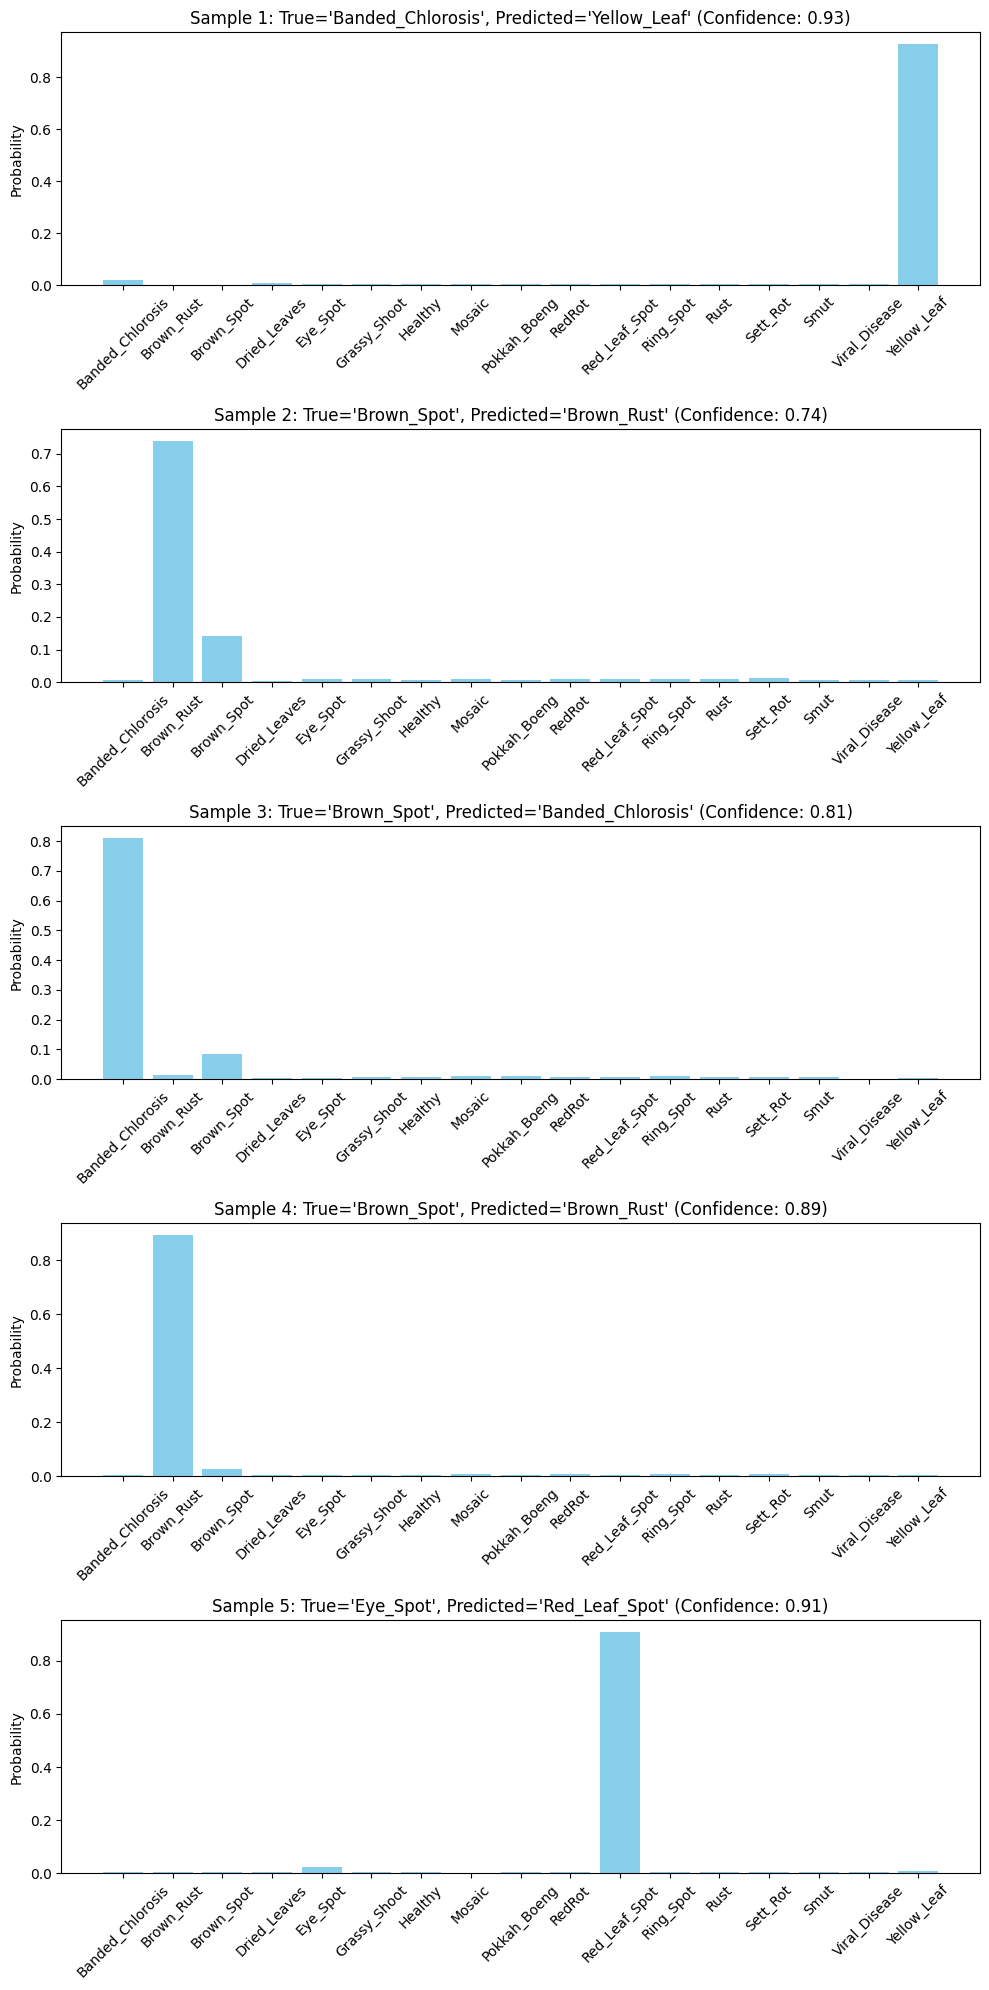

In [2]:
# Get class names in correct order for reports
class_names_report = [int_to_class[i] for i in range(num_classes)]

# a) Convergence Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.tight_layout()
plt.savefig('./efficientnet_lite_outputs/convergence_plots.png')
print("Saved convergence plots to ./efficientnet_lite_outputs/convergence_plots.png")

# b) Classification Report
report = classification_report(test_targets, test_preds, target_names=class_names_report, zero_division=0)
print("\nClassification Report (Test Set):\n", report)
with open("./efficientnet_lite_outputs/classification_report.txt", "w") as f:
    f.write(report)
    
# c) Confusion Matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_report, yticklabels=class_names_report)
plt.title('Confusion Matrix (Test Set)'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./efficientnet_lite_outputs/confusion_matrix.png')
print("Saved confusion matrix to ./efficientnet_lite_outputs/confusion_matrix.png")

# Binarize labels for multi-class ROC/PR curves
y_true_bin = label_binarize(test_targets, classes=range(num_classes))

# d) ROC-AUC Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names_report[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right")
plt.savefig('./efficientnet_lite_outputs/roc_auc_curve.png')
print("Saved ROC-AUC curve to ./efficientnet_lite_outputs/roc_auc_curve.png")

# e) Precision-Recall Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], test_outputs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], test_outputs[:, i])
    plt.plot(recall, precision, label=f'PR curve for {class_names_report[i]} (AP = {avg_precision:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve'); plt.legend(loc="best")
plt.savefig('./efficientnet_lite_outputs/precision_recall_curve.png')
print("Saved Precision-Recall curve to ./efficientnet_lite_outputs/precision_recall_curve.png")

# --- 8. t-SNE Visualization ---
def extract_features(model, loader, device):
    """
    Extracts deep features from the model for t-SNE visualization.
    """
    features = []
    labels = []
    model.eval()
    
    original_classifier = model.base_model.classifier
    model.base_model.classifier = nn.Identity()
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting features for t-SNE"):
            data = data.to(device)
            output = model(data)
            features.append(output.cpu().numpy())
            labels.append(target.numpy())
            
    model.base_model.classifier = original_classifier
    return np.concatenate(features), np.concatenate(labels)

print("\n--- Generating t-SNE visualizations ---")
features, tsne_labels = extract_features(best_model, test_loader, device)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(30, len(features)-1), n_iter=1000, init='pca')
tsne_results = tsne.fit_transform(features)

# Get prediction confidence scores for the test set
confidences = np.max(test_outputs, axis=1)

# f) t-SNE plot colored by true labels
plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=[class_names_report[l] for l in tsne_labels], palette=sns.color_palette("hsv", num_classes), s=50, alpha=0.7)
plt.title('t-SNE of Image Features by True Class'); plt.legend(loc='best')
plt.savefig('./efficientnet_lite_outputs/tsne_by_class.png')
print("Saved t-SNE plot by class to ./efficientnet_lite_outputs/tsne_by_class.png")

# g) t-SNE plot colored by confidence
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=confidences, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='Prediction Confidence')
plt.title('t-SNE of Image Features by Prediction Confidence')
plt.savefig('./efficientnet_lite_outputs/tsne_by_confidence.png')
print("Saved t-SNE plot by confidence to ./efficientnet_lite_outputs/tsne_by_confidence.png")

# h) Confidence Bar Plots for Misclassified Images
misclassified_indices = np.where(np.array(test_preds) != np.array(test_targets))[0]
if len(misclassified_indices) > 0:
    print(f"\nFound {len(misclassified_indices)} misclassified images. Plotting confidence for a few examples.")
    num_to_plot = min(len(misclassified_indices), 5)
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(10, num_to_plot * 4))
    if num_to_plot == 1: axes = [axes] # Make it iterable
    for i, idx in enumerate(misclassified_indices[:num_to_plot]):
        true_label = class_names_report[test_targets[idx]]
        pred_label = class_names_report[test_preds[idx]]
        probs = test_outputs[idx]
        
        axes[i].bar(class_names_report, probs, color='skyblue')
        axes[i].set_title(f"Sample {i+1}: True='{true_label}', Predicted='{pred_label}' (Confidence: {probs[test_preds[idx]]:.2f})")
        axes[i].set_ylabel("Probability")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('./efficientnet_lite_outputs/misclassified_confidence.png')
    print("Saved confidence plots for misclassified samples to ./efficientnet_lite_outputs/misclassified_confidence.png")
else:
    print("\nNo misclassified images found in the test set. Perfect score!")

print("\nScript finished successfully. All artifacts are in the './efficientnet_lite_outputs' directory.")